# Train Models

## Set-up

In [0]:
#@title Run in google colab?
# this is to make use of gpu on colab.
# set to false if running locally on jupyter notebook
google_colab = True #@param {type:"boolean"}

In [2]:
# mount google drive if running from colab
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# install facenet-pytorch if using colab
if google_colab:
    !pip install facenet-pytorch
    !pip uninstall opencv-python -y
    !pip install opencv-contrib-python==3.4.2.17 --force-reinstall

     |████████████████████████████████| 1.9MB 10.2MB/s 
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 102kB/s 
     |████████████████████████████████| 20.2MB 64.7MB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.2
    Uninstalling numpy-1.18.2:
      Successfully uninstalled numpy-1.18.2
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2

In [0]:
# set folder paths to fetch faces and to save trained models
train_path = '../data/train'
models_path = '../models'

In [5]:
#import relevant libraries
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import datasets, transforms, models
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np
import pandas as pd
import math
import random
import time
import os
import glob
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
from PIL import Image
from skimage import io, transform
from sklearn.svm import SVC
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import random
from itertools import product

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# move to same directory where this notebook is (if using colab)
if google_colab:
    os.chdir('/content/drive/My Drive/MSc Data Science/Computer Vision/Coursework/code')

In [0]:
# import utils package with custom methods created for this project
import utils

In [8]:
#check gpu is enabled
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [9]:
# set random seed for reproducibility
torch.manual_seed(0)

In [0]:
# create models directory (if it doesn't exist)
if not os.path.exists(models_path):
    os.makedirs(models_path)

## Set up data loading

In [0]:
# use ImageFolder to get labels
data = datasets.ImageFolder(train_path)
idx_to_label = {i:c for c, i in data.class_to_idx.items()}
label_to_idx = {i:c for i, c in data.class_to_idx.items()}
labels = data.classes

In [0]:
# initialise data dicts
train_dict = {label: [] for label in labels}
val_dict = {label: [] for label in labels}
test_i_dict = {label: [] for label in labels}
test_g_dict = {label: [] for label in labels}
test_dict = {label: [] for label in labels}

random.seed(1)

# loop through label directories
for label in labels:
    # pick up group image paths
    image_paths = [image_path for image_path in glob.glob(f'{train_path}/{label}/*_g_*')]
    # get train/test split index
    split = int(math.ceil(0.2 * len(image_paths)))
    # shuffle image paths
    random.shuffle(image_paths)
    # do train/test split
    test = image_paths[:split]
    train = image_paths[split:]
    # get train/val split index
    split = int(math.ceil(0.2 * len(train)))
    # shuffle image names
    random.shuffle(train)
    # do train/val split
    val = train[:split]
    train = train[split:]
    # save image paths in dicts
    train_dict[label].extend([image_path for image_path in train])
    val_dict[label].extend([image_path for image_path in val])
    test_g_dict[label].extend([image_path for image_path in test])
    test_dict[label].extend([image_path for image_path in test])

    # pick up group image paths
    image_paths = [image_path for image_path in glob.glob(f'{train_path}/{label}/*_i_*')]
    # get train/test split index
    split = int(math.ceil(0.2 * len(image_paths)))
    # shuffle image paths
    random.shuffle(image_paths)
    # do train/test split
    test = image_paths[:split]
    train = image_paths[split:]
    # get train/val split index
    split = int(math.ceil(0.2 * len(train)))
    # shuffle image names
    random.shuffle(train)
    # do train/val split
    val = train[:split]
    train = train[split:]
    # save image paths in dicts
    train_dict[label].extend([image_path for image_path in train])
    val_dict[label].extend([image_path for image_path in val])
    test_i_dict[label].extend([image_path for image_path in test])
    test_dict[label].extend([image_path for image_path in test])

In [0]:
# turn dicts into list of tuples
train = []
val = []
test_i = []
test_g = []
test = []
for label in labels:
    train.extend([(image_path, label_to_idx[label]) for image_path in train_dict[label]])
    val.extend([(image_path, label_to_idx[label]) for image_path in val_dict[label]])
    test_i.extend([(image_path, label_to_idx[label]) for image_path in test_i_dict[label]])
    test_g.extend([(image_path, label_to_idx[label]) for image_path in test_g_dict[label]])
    test.extend([(image_path, label_to_idx[label]) for image_path in test_dict[label]])
    
# shuffle tuples
random.shuffle(train)
random.shuffle(val)
random.shuffle(test_i)
random.shuffle(test_g)
random.shuffle(test)

In [14]:
# print dataset sizes
{'train': len(train), 'val': len(val), 'test': len(test), 'test_i': len(test_i), 'test_g': len(test_g)}

{'test': 267, 'test_g': 170, 'test_i': 97, 'train': 612, 'val': 186}

In [0]:
# create custom dataset
class CustomDataset(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data[idx][0]
        label = self.data[idx][1]
        image = Image.open(img_name)
        if self.transform:
            sample = (self.transform(image),label)
        else:
            sample = (image,label)
        return sample

## AlexNet (CNN)

### Load data

In [0]:
# train data transforms
train_transform = transforms.Compose([
                                      utils.AugSeq(),
                                      transforms.ToTensor(), 
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

# val data transforms
val_transform = transforms.Compose([
                                    transforms.ToTensor(), 
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

In [0]:
# load train data
train_faces = CustomDataset(train, transform=train_transform)

# load val data
val_faces = CustomDataset(val, transform=val_transform)

dataset_sizes = {'train': len(train_faces), 'val': len(val_faces)}

In [0]:
# create train, val data loaders
train_loader = DataLoader(train_faces, batch_size=32, num_workers=0)
val_loader = DataLoader(val_faces, batch_size=32, num_workers=0)

dataloaders = {'train': train_loader, 'val': val_loader}

In [0]:
# load training data

images_train = []
labels_train = []

for images, labels_ in dataloaders['train']:
    images_train.extend(images)
    labels_train.extend(labels_)

In [0]:
# load validation data

images_val = []
labels_val = []
for images, labels_ in dataloaders['val']:
    images_val.extend(images)
    labels_val.extend(labels_)

### Show data

In [0]:
images = []
for image in images_train:
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    images.append(image)

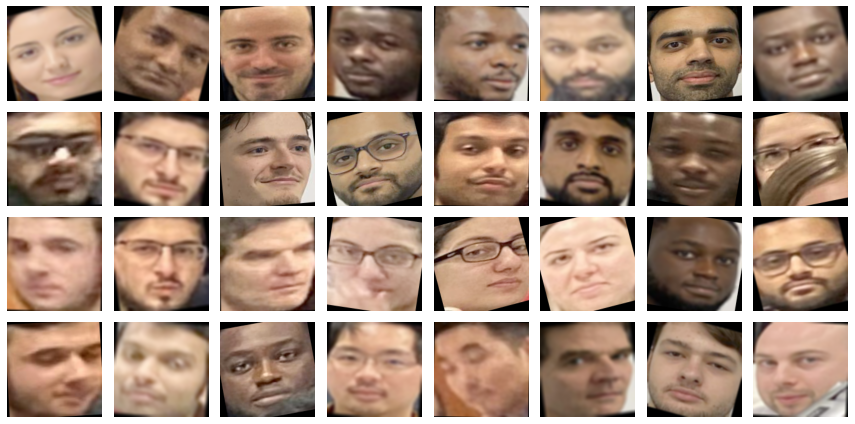

In [0]:
# show sample train images
utils.imshow(images)

In [0]:
images = []
for image in images_val:
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    images.append(image)

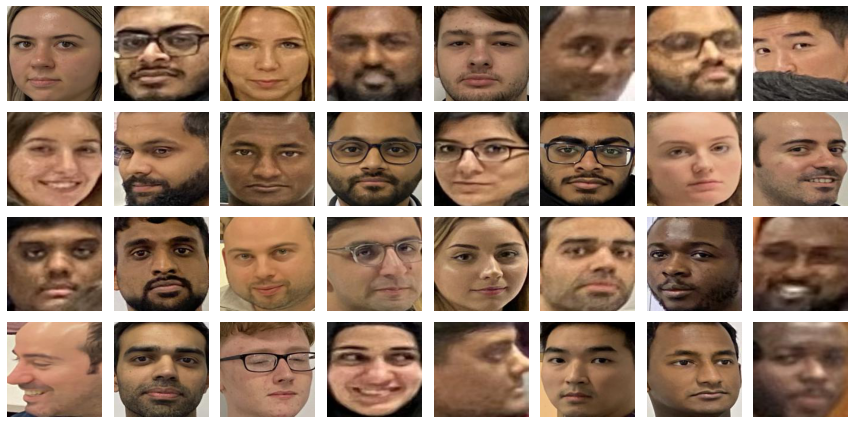

In [0]:
# show sample val images
utils.imshow(images)

### Train model

In [0]:
# adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return train_losses, train_accs, val_losses, val_accs, model

In [0]:
# set up alexnet pre-trained model
# taken from the pytorch torchvision library, 
# more info here: https://pytorch.org/docs/stable/torchvision/models.html

alexnet_ft = models.alexnet(pretrained=True)

# reshape last layer of alexnet to deal with number of labels in our data
num_ftrs = alexnet_ft.classifier[6].in_features
# Here the size of each output sample is set to nn.Linear(num_ftrs, len(class_names)).
alexnet_ft.classifier[6] = nn.Linear(num_ftrs, len(labels))

# set model parameters to compute device available
alexnet_ft = alexnet_ft.to(device)

# set loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(alexnet_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
# train model
train_loss, train_acc, \
val_loss, val_acc, alexnet_ft = train_model(alexnet_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/39
----------
train Loss: 3.6726 Acc: 0.0948
val Loss: 3.1211 Acc: 0.1667

Epoch 1/39
----------
train Loss: 2.6932 Acc: 0.3170
val Loss: 2.2358 Acc: 0.3763

Epoch 2/39
----------
train Loss: 1.8040 Acc: 0.4837
val Loss: 1.5981 Acc: 0.5269

Epoch 3/39
----------
train Loss: 1.1957 Acc: 0.6356
val Loss: 1.3341 Acc: 0.6505

Epoch 4/39
----------
train Loss: 0.7838 Acc: 0.7663
val Loss: 1.0012 Acc: 0.7204

Epoch 5/39
----------
train Loss: 0.7515 Acc: 0.7827
val Loss: 1.1433 Acc: 0.6613

Epoch 6/39
----------
train Loss: 0.7744 Acc: 0.7712
val Loss: 0.9010 Acc: 0.7097

Epoch 7/39
----------
train Loss: 0.5048 Acc: 0.8464
val Loss: 0.6261 Acc: 0.7903

Epoch 8/39
----------
train Loss: 0.2702 Acc: 0.9248
val Loss: 0.5841 Acc: 0.8118

Epoch 9/39
----------
train Loss: 0.2280 Acc: 0.9412
val Loss: 0.5212 Acc: 0.8172

Epoch 10/39
----------
train Loss: 0.1861 Acc: 0.9575
val Loss: 0.4842 Acc: 0.8387

Epoch 11/39
----------
train Loss: 0.1797 Acc: 0.9461
val Loss: 0.4761 Acc: 0.8441

Ep

### Show stats

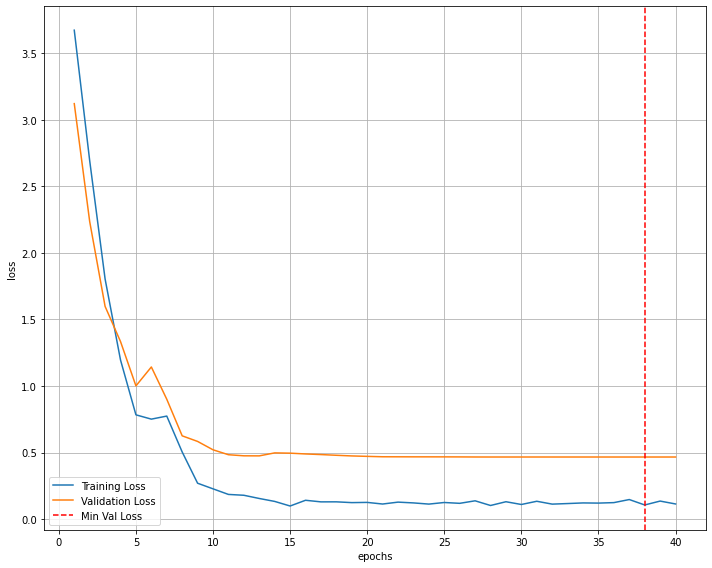

In [0]:
# adapted from https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = val_loss.index(min(val_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Min Val Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#fig.savefig('loss_plot.png', bbox_inches='tight')

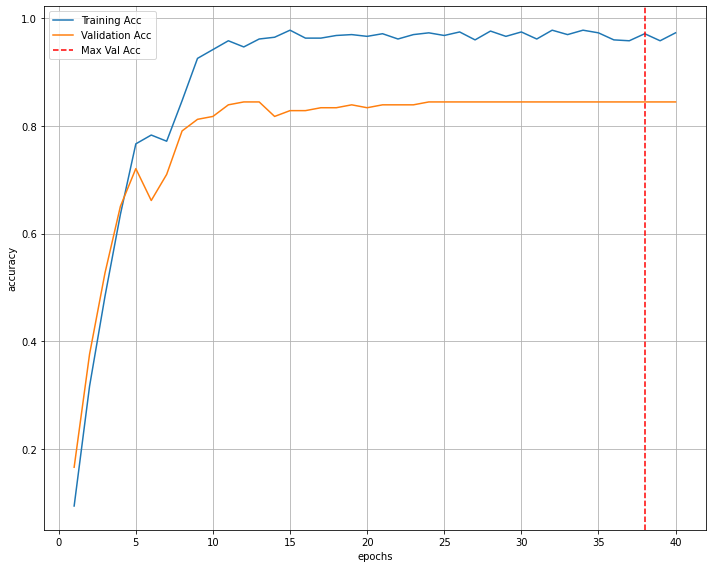

In [0]:
# adapted from https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Acc')
plt.plot(range(1,len(val_acc)+1),val_acc,label='Validation Acc')

# find position of lowest validation loss
minposs = val_loss.index(min(val_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Max Val Acc')

plt.xlabel('epochs')
plt.ylabel('accuracy')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#fig.savefig('loss_plot.png', bbox_inches='tight')

### Show outputs

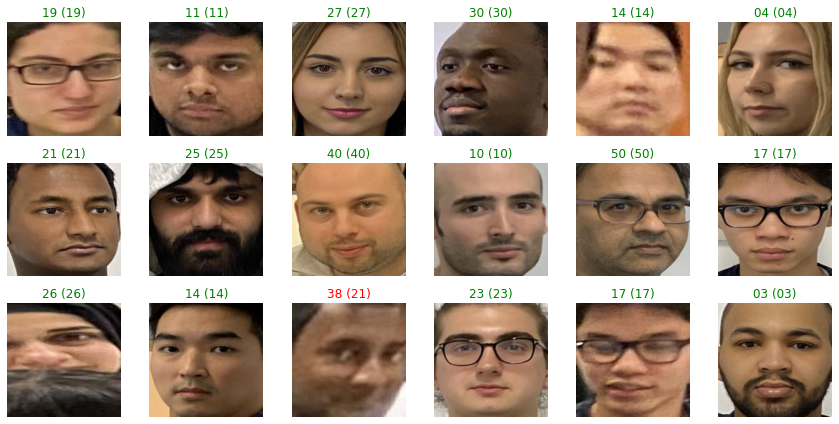

In [0]:
utils.visualise_cnn(alexnet_ft, images,labels_val, labels)

### Save model

In [0]:
# save model down
torch.save(alexnet_ft.state_dict(), models_path + '/alexnet_ft.pt')

### Test model

In [0]:
# load test data (all)
test_faces = CustomDataset(test, transform=val_transform)
test_inputs = torch.stack([sample[0] for sample in test_faces]).to(device)
test_labels = [sample[1] for sample in test_faces]

# load test data (individual images)
test_i_faces = CustomDataset(test_i, transform=val_transform)
test_i_inputs = torch.stack([sample[0] for sample in test_i_faces]).to(device)
test_i_labels = [sample[1] for sample in test_i_faces]

# load test data (group images)
test_g_faces = CustomDataset(test_g, transform=val_transform)
test_g_inputs = torch.stack([sample[0] for sample in test_g_faces]).to(device)
test_g_labels = [sample[1] for sample in test_g_faces]

In [0]:
# get predictions (entire test set)
outputs = alexnet_ft(test_inputs)
scores, preds = outputs.max(1)
preds = preds.cpu().detach().numpy()

# get predictions (individual images)
outputs_i = alexnet_ft(test_i_inputs)
scores_i, preds_i = outputs_i.max(1)
preds_i = preds_i.cpu().detach().numpy()

# get predictions (group images)
outputs_g = alexnet_ft(test_g_inputs)
scores_g, preds_g = outputs_g.max(1)
preds_g = preds_g.cpu().detach().numpy()

In [0]:
# get test set accuracy
acc_test = np.sum(preds == test_labels) / len(test_labels)
acc_test_i = np.sum(preds_i == test_i_labels) / len(test_i_labels)
acc_test_g = np.sum(preds_g == test_g_labels) / len(test_g_labels)

In [0]:
# print test set accuracy
{'test (all)': round(acc_test,3), 'test (i)': round(acc_test_i,3), 'test (g)': round(acc_test_g,3)}

{'test (all)': 0.854, 'test (g)': 0.841, 'test (i)': 0.876}

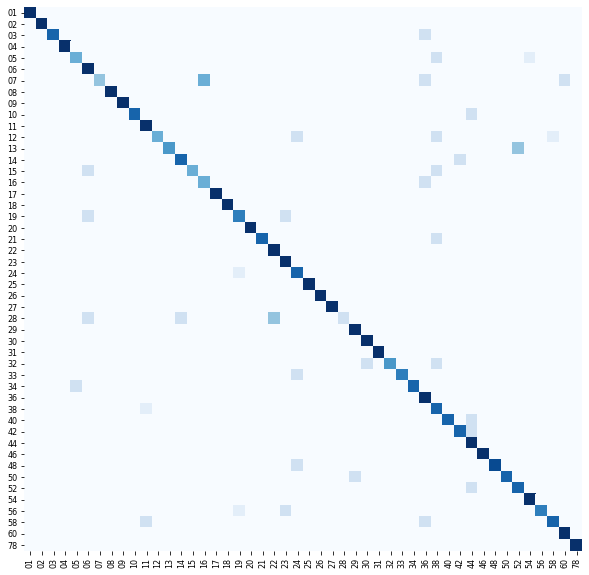

In [0]:
cm = confusion_matrix(test_labels, preds)
cm_df = pd.DataFrame(data=(cm/cm.sum(axis=1)).round(1), columns=labels, index=labels)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df,cmap=plt.cm.Blues,cbar=False)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

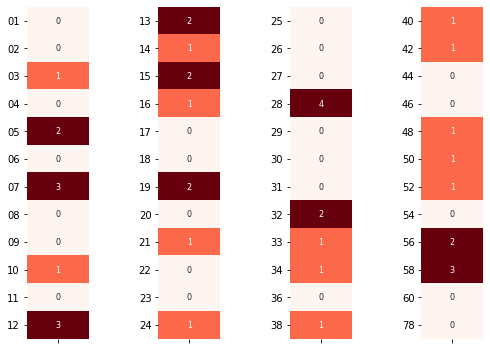

In [0]:
# show model's incorrect predictions per class
mistakes = cm.sum(axis=1) - np.diag(cm)

m_df_1 = pd.DataFrame(data=mistakes[0:12],columns=[''],index=labels[0:12])
m_df_2 = pd.DataFrame(data=mistakes[12:24],columns=[''],index=labels[12:24])
m_df_3 = pd.DataFrame(data=mistakes[24:36],columns=[''],index=labels[24:36])
m_df_4 = pd.DataFrame(data=mistakes[36:48],columns=[''],index=labels[36:48])

fig, ax = plt.subplots(1,4,figsize=(8,6))

sns.heatmap(m_df_1,cmap=plt.cm.Reds,vmin=0,vmax=2,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[0])
sns.heatmap(m_df_2,cmap=plt.cm.Reds,vmin=0,vmax=2,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[1])
sns.heatmap(m_df_3,cmap=plt.cm.Reds,vmin=0,vmax=2,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[2])
sns.heatmap(m_df_4,cmap=plt.cm.Reds,vmin=0,vmax=2,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[3])

ax[0].set_yticklabels(labels[0:12],rotation=0)
ax[1].set_yticklabels(labels[12:24],rotation=0)
ax[2].set_yticklabels(labels[24:36],rotation=0)
ax[3].set_yticklabels(labels[36:48],rotation=0)

plt.tight_layout(pad=5.0)
plt.show()

## Load data

### Load data

In [0]:
# data transforms with augmentation
transform_aug = transforms.Compose([
                                utils.AugSeq(),
                                transforms.Grayscale(num_output_channels=1)
                                ])

# data transforms no augmentation
transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=1)
                                ])

In [0]:
# load train data
train_faces = CustomDataset(train, transform=transform_aug)

# load val data
val_faces = CustomDataset(val, transform=transform)

In [0]:
def collate_fn(batch):
    if len(batch) == 1:
        data, target = batch[0]
    else:
        data = [item[0] for item in batch]
        target = [item[1] for item in batch]
    return [data, target]

# create train, val data loaders
train_loader = DataLoader(train_faces, batch_size=32, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_faces, batch_size=32, num_workers=0, collate_fn=collate_fn)
dataloaders = {'train': train_loader, 'val': val_loader}

In [0]:
# load training data

num_augs = 10

images_train = []
labels_train = []

for aug in range(num_augs):
    for images, labels_ in dataloaders['train']:
        images_train.extend(images)
        labels_train.extend(labels_)

In [0]:
# load validation data

images_val = []
labels_val = []
for images, labels_ in dataloaders['val']:
    images_val.extend(images)
    labels_val.extend(labels_)

In [21]:
{'train': len(images_train), 'val': len(images_val)}

{'train': 6120, 'val': 186}

### Show data

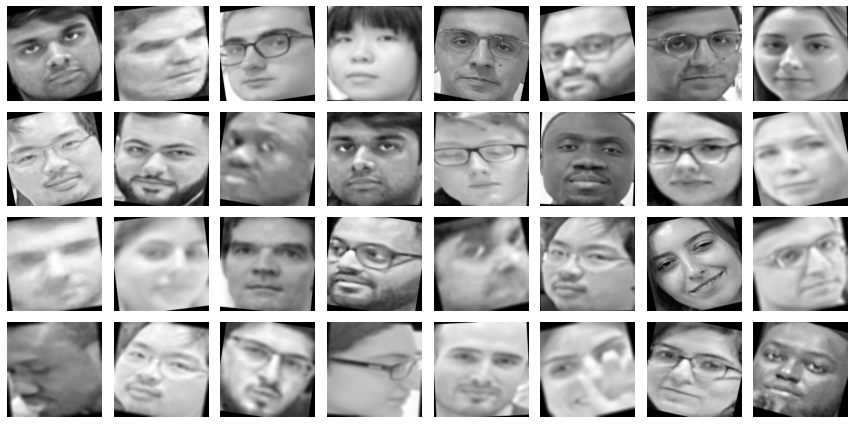

In [0]:
utils.imshow(images_train)

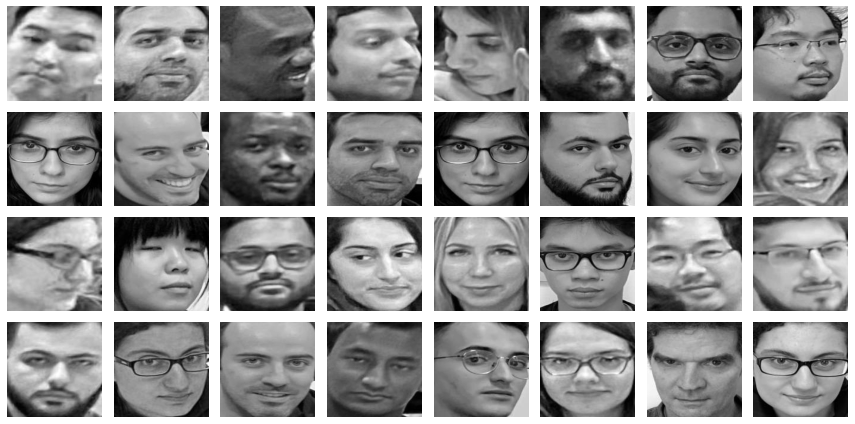

In [0]:
utils.imshow(images_val)

## PCA-SVM

### Train model

In [0]:
def svm_hp_tuning(pca_n_comps, Cs, images_train, labels_train, images_val, labels_val):
    hp_choices = list(product(pca_n_comps,Cs))
    train_accs = []
    val_accs = []
    best_acc = 0
    for i, hp_choice in enumerate(hp_choices):
        #preprocess images
        extractor = utils.pca_extractor(pca_train_data=images_train, pca_n_comps=hp_choice[0])
        images_train_encoded = extractor(images_train)
        images_val_encoded = extractor(images_val)
        #fit model
        svc = SVC(C=hp_choice[1], decision_function_shape='ovo')
        svc.fit(images_train_encoded, labels_train)
        #predict
        preds_train = svc.predict(images_train_encoded)
        preds_val = svc.predict(images_val_encoded)
        acc_train = np.sum(preds_train == labels_train) / len(labels_train)
        acc_val = np.sum(preds_val == labels_val) / len(labels_val)

        train_accs.append(acc_train)
        val_accs.append(acc_val)

        print(f'({i+1}/{len(hp_choices)})', 'pca_n:', hp_choice[0], ', C:', hp_choice[1], \
              ', train acc:', round(acc_train,3), ', val acc:', round(acc_val,3))

        #save best hyperparams
        if acc_val > best_acc:
          best_acc = acc_val
          best_hps = {'pca_n': hp_choice[0], 'C': hp_choice[1]}
          #print('saving model...')
          #best_svm = SVC(C=hp_choice[1], decision_function_shape='ovo',probability=True)
          #best_svm.fit(images_train_encoded, labels_train)

    return train_accs, val_accs, best_hps

In [0]:
# choose hyperparameter ranges
pca_n_comps = np.logspace(1, 2.5, 5, dtype=int).tolist()
Cs = np.logspace(-1, 1.5, 5).round(2).tolist()

# run hyperparameter tuning
train_accs, val_accs, best_hps = svm_hp_tuning(pca_n_comps, Cs, images_train, labels_train, images_val, labels_val)

(1/25) pca_n: 10 , C: 0.1 , train acc: 0.424 , val acc: 0.312
(2/25) pca_n: 10 , C: 0.42 , train acc: 0.673 , val acc: 0.478
(3/25) pca_n: 10 , C: 1.78 , train acc: 0.858 , val acc: 0.629
(4/25) pca_n: 10 , C: 7.5 , train acc: 0.958 , val acc: 0.651
(5/25) pca_n: 10 , C: 31.62 , train acc: 0.994 , val acc: 0.645
(6/25) pca_n: 23 , C: 0.1 , train acc: 0.471 , val acc: 0.376
(7/25) pca_n: 23 , C: 0.42 , train acc: 0.808 , val acc: 0.645
(8/25) pca_n: 23 , C: 1.78 , train acc: 0.979 , val acc: 0.747
(9/25) pca_n: 23 , C: 7.5 , train acc: 0.999 , val acc: 0.753
(10/25) pca_n: 23 , C: 31.62 , train acc: 1.0 , val acc: 0.758
(11/25) pca_n: 56 , C: 0.1 , train acc: 0.492 , val acc: 0.398
(12/25) pca_n: 56 , C: 0.42 , train acc: 0.894 , val acc: 0.688
(13/25) pca_n: 56 , C: 1.78 , train acc: 0.996 , val acc: 0.785
(14/25) pca_n: 56 , C: 7.5 , train acc: 1.0 , val acc: 0.796
(15/25) pca_n: 56 , C: 31.62 , train acc: 1.0 , val acc: 0.796
(16/25) pca_n: 133 , C: 0.1 , train acc: 0.484 , val acc: 

In [0]:
best_hps

{'C': 7.5, 'pca_n': 133}

In [23]:
# instantiate best model
extractor = utils.pca_extractor(pca_train_data=images_train, pca_n_comps=133)
images_train_encoded = extractor(images_train)
images_val_encoded = extractor(images_val)

svc = SVC(C=7.5, decision_function_shape='ovo', probability=True)
svc.fit(images_train_encoded, labels_train)

preds_train = svc.predict(images_train_encoded)
preds_val = svc.predict(images_val_encoded)
acc_train = np.sum(preds_train == labels_train) / len(labels_train)
acc_val = np.sum(preds_val == labels_val) / len(labels_val)

print('train acc:', round(acc_train,2))
print('val acc:', round(acc_val,2))

train acc: 1.0
val acc: 0.83


### Show Stats

In [0]:
# visualise average train/val accuracy as hyperparameters vary
hp_choices = list(product(pca_n_comps,Cs))
hp_choices_pca = np.array([hp_choice[0] for hp_choice in hp_choices])
hp_choices_Cs = np.array([hp_choice[1] for hp_choice in hp_choices])
train_accs_2 = np.array(train_accs)
val_accs_2 = np.array(val_accs)

train_accs_m_pca_n = [np.median(train_accs_2[hp_choices_pca==pca_n]) for pca_n in pca_n_comps]
val_accs_m_pca_n = [np.median(val_accs_2[hp_choices_pca==pca_n]) for pca_n in pca_n_comps]
train_accs_m_c = [np.median(train_accs_2[hp_choices_Cs==C]) for C in Cs]
val_accs_m_c = [np.median(val_accs_2[hp_choices_Cs==C]) for C in Cs]

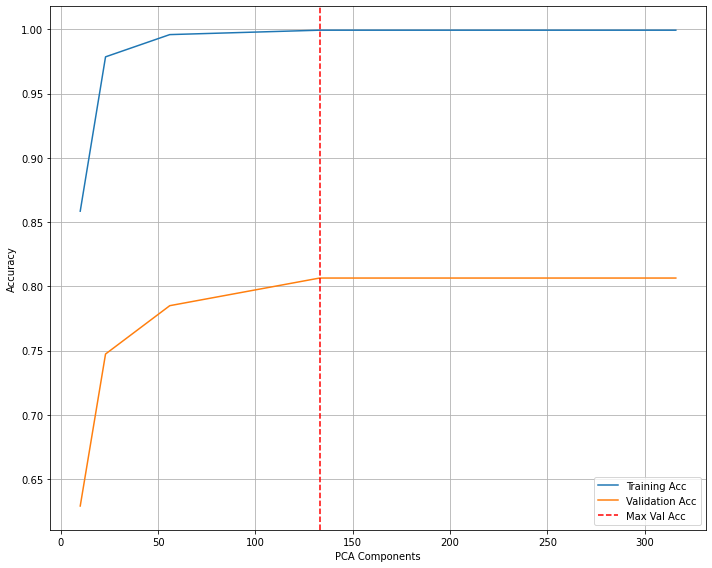

In [0]:
# pca number of components
fig = plt.figure(figsize=(10,8))
plt.plot(pca_n_comps,train_accs_m_pca_n, label='Training Acc')
plt.plot(pca_n_comps,val_accs_m_pca_n,label='Validation Acc')

# find position of highest validation acc
maxposs = val_accs_m_pca_n.index(max(val_accs_m_pca_n)) 
plt.axvline(pca_n_comps[maxposs], linestyle='--', color='r',label='Max Val Acc')

plt.xlabel('PCA Components')
plt.ylabel('Accuracy')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#fig.savefig('loss_plot.png', bbox_inches='tight')

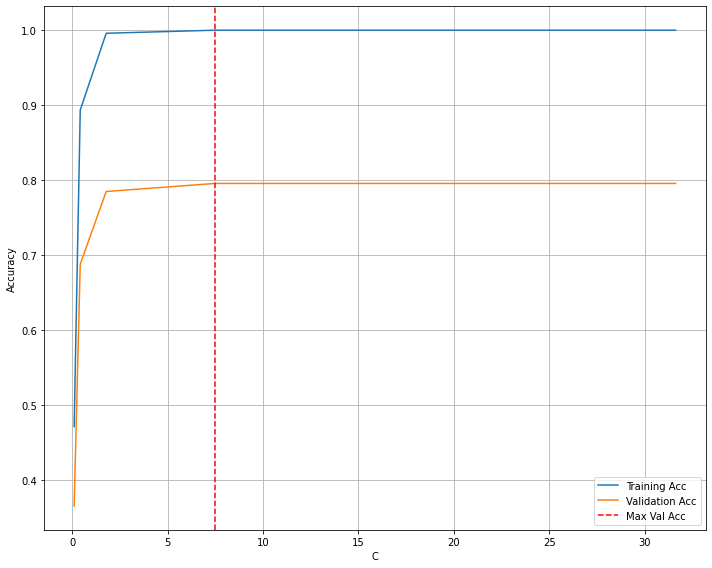

In [0]:
# SVM C regularisation parameter
fig = plt.figure(figsize=(10,8))
plt.plot(Cs,train_accs_m_c, label='Training Acc')
plt.plot(Cs,val_accs_m_c,label='Validation Acc')

# find position of highest validation acc
maxposs = val_accs_m_c.index(max(val_accs_m_c)) 
plt.axvline(Cs[maxposs], linestyle='--', color='r',label='Max Val Acc')

plt.xlabel('C')
plt.ylabel('Accuracy')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#fig.savefig('loss_plot.png', bbox_inches='tight')

### Show outputs

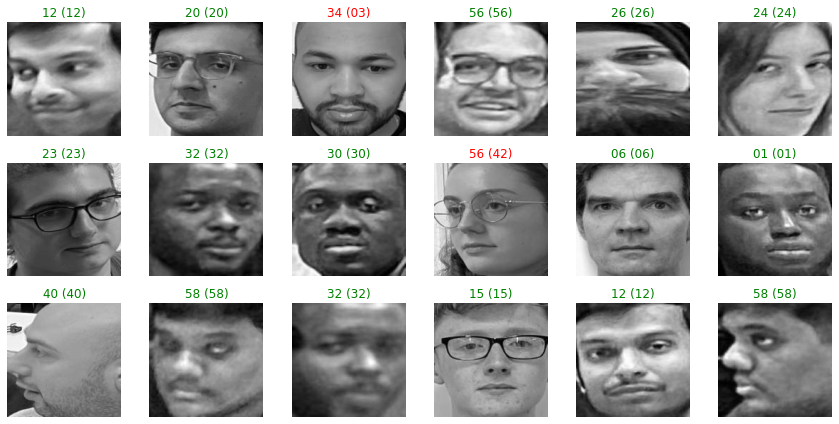

In [24]:
utils.visualise_svm(svc, extractor, images_val, labels_val, labels)

### Save model

In [25]:
# save pca for feature extraction
from joblib import dump, load
dump(extractor.pca, models_path + '/pca.joblib')

['../models/pca.joblib']

In [26]:
# save model
from joblib import dump, load
dump(svc, models_path + '/pca_svm.joblib') 

['../models/pca_svm.joblib']

### Test model

In [0]:
# load test data (all)
test_faces = CustomDataset(test, transform=transform)
test_inputs = extractor([sample[0] for sample in test_faces])
test_labels = [sample[1] for sample in test_faces]

# load test data (individual images)
test_i_faces = CustomDataset(test_i, transform=transform)
test_i_inputs = extractor([sample[0] for sample in test_i_faces])
test_i_labels = [sample[1] for sample in test_i_faces]

# load test data (group images)
test_g_faces = CustomDataset(test_g, transform=transform)
test_g_inputs = extractor([sample[0] for sample in test_g_faces])
test_g_labels = [sample[1] for sample in test_g_faces]

In [0]:
# get predictions (entire test set)
preds = svc.predict(test_inputs)

# get predictions (individual images)
preds_i = svc.predict(test_i_inputs)

# get predictions (group images)
preds_g = svc.predict(test_g_inputs)

In [0]:
# get test set accuracy
acc_test = np.sum(preds == test_labels) / len(test_labels)
acc_test_i = np.sum(preds_i == test_i_labels) / len(test_i_labels)
acc_test_g = np.sum(preds_g == test_g_labels) / len(test_g_labels)

In [30]:
# print test set accuracy
{'test (all)': round(acc_test,3), 'test (i)': round(acc_test_i,3), 'test (g)': round(acc_test_g,3)}

{'test (all)': 0.768, 'test (g)': 0.771, 'test (i)': 0.763}

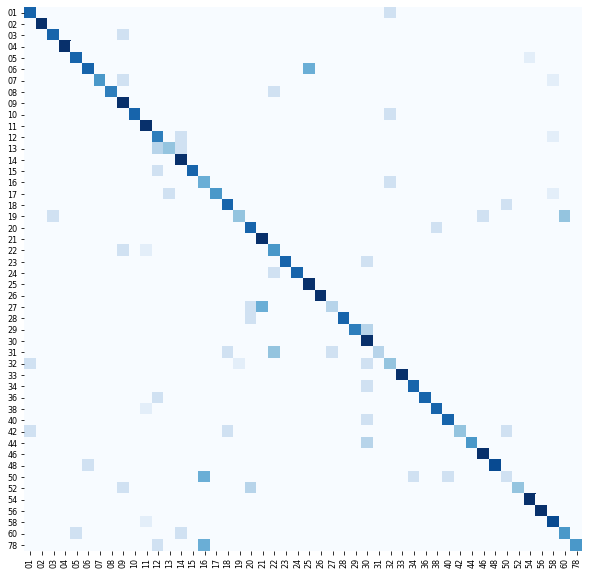

In [31]:
cm = confusion_matrix(test_labels, preds)
cm_df = pd.DataFrame(data=(cm/cm.sum(axis=1)).round(1), columns=labels, index=labels)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df,cmap=plt.cm.Blues,cbar=False)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

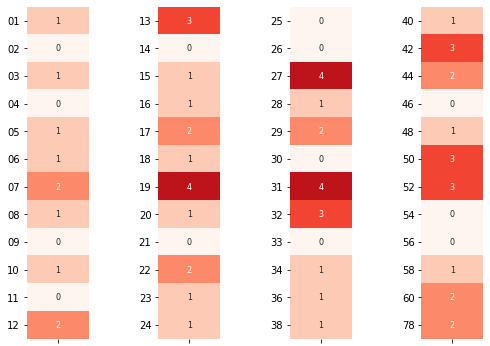

In [32]:
# show model's incorrect predictions per class
mistakes = cm.sum(axis=1) - np.diag(cm)

m_df_1 = pd.DataFrame(data=mistakes[0:12],columns=[''],index=labels[0:12])
m_df_2 = pd.DataFrame(data=mistakes[12:24],columns=[''],index=labels[12:24])
m_df_3 = pd.DataFrame(data=mistakes[24:36],columns=[''],index=labels[24:36])
m_df_4 = pd.DataFrame(data=mistakes[36:48],columns=[''],index=labels[36:48])

fig, ax = plt.subplots(1,4,figsize=(8,6))

sns.heatmap(m_df_1,cmap=plt.cm.Reds,vmin=0,vmax=5,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[0])
sns.heatmap(m_df_2,cmap=plt.cm.Reds,vmin=0,vmax=5,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[1])
sns.heatmap(m_df_3,cmap=plt.cm.Reds,vmin=0,vmax=5,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[2])
sns.heatmap(m_df_4,cmap=plt.cm.Reds,vmin=0,vmax=5,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[3])

ax[0].set_yticklabels(labels[0:12],rotation=0)
ax[1].set_yticklabels(labels[12:24],rotation=0)
ax[2].set_yticklabels(labels[24:36],rotation=0)
ax[3].set_yticklabels(labels[36:48],rotation=0)

plt.tight_layout(pad=5.0)
plt.show()

## SURF-SVM

### Train model

In [0]:
def svm_hp_tuning(hessian_t, kmeans_k, Cs, images_train, labels_train, images_val, labels_val):
    hp_choices = list(product(hessian_t,kmeans_k,Cs))
    train_accs = []
    val_accs = []
    best_acc = 0
    for i, hp_choice in enumerate(hp_choices):
        ht = hp_choice[0] 
        k = hp_choice[1]
        C = hp_choice[2]

        #preprocess images
        extractor = utils.surf_extractor(kmeans_train_data=images_train, hessian_threshold=ht, n_clusters=k)
        images_train_encoded = extractor(images_train, surf_extraction=False)
        images_val_encoded = extractor(images_val)
        #fit model
        svc = SVC(C=C, decision_function_shape='ovo')
        svc.fit(images_train_encoded, labels_train)
        #predict
        preds_train = svc.predict(images_train_encoded)
        preds_val = svc.predict(images_val_encoded)

        acc_train = np.sum(preds_train == labels_train) / len(labels_train)
        acc_val = np.sum(preds_val == labels_val) / len(labels_val)

        train_accs.append(acc_train)
        val_accs.append(acc_val)

        print(f'({i+1}/{len(hp_choices)})', 'hessian_t:', ht, ', kmeans_n:', k, ', C:', C,\
              ', train acc:', round(acc_train,3), ', val acc:', round(acc_val,3))

        #save best hyperparams
        if acc_val > best_acc:
            best_acc = acc_val
            best_hps = {'hessian_t': ht, 'kmeans_n': k, 'C': C}
            #print('saving model...')
            #best_svm = SVC(C=hp_choice[1], decision_function_shape='ovo',probability=True)
            #best_svm.fit(images_train_encoded, labels_train)

    return train_accs, val_accs, best_hps

In [0]:
# choose hyperparameter ranges
hessian_t = np.logspace(1.5,2.7,4,dtype=int).tolist()
kmeans_k = np.logspace(1,2.5,4,dtype=int).tolist()
Cs = np.logspace(-1, 1.5, 4).round(2).tolist()

# run hyperparameter tuning
train_accs, val_accs, best_hps = svm_hp_tuning(hessian_t, kmeans_k, Cs, images_train, labels_train, 
                                               images_val, labels_val)

(1/64) hessian_t: 31 , kmeans_n: 10 , C: 0.1 , train acc: 0.275 , val acc: 0.177
(2/64) hessian_t: 31 , kmeans_n: 10 , C: 0.68 , train acc: 0.429 , val acc: 0.258
(3/64) hessian_t: 31 , kmeans_n: 10 , C: 4.64 , train acc: 0.608 , val acc: 0.274
(4/64) hessian_t: 31 , kmeans_n: 10 , C: 31.62 , train acc: 0.836 , val acc: 0.231
(5/64) hessian_t: 31 , kmeans_n: 31 , C: 0.1 , train acc: 0.335 , val acc: 0.22
(6/64) hessian_t: 31 , kmeans_n: 31 , C: 0.68 , train acc: 0.731 , val acc: 0.398
(7/64) hessian_t: 31 , kmeans_n: 31 , C: 4.64 , train acc: 0.959 , val acc: 0.441
(8/64) hessian_t: 31 , kmeans_n: 31 , C: 31.62 , train acc: 1.0 , val acc: 0.452
(9/64) hessian_t: 31 , kmeans_n: 100 , C: 0.1 , train acc: 0.366 , val acc: 0.253
(10/64) hessian_t: 31 , kmeans_n: 100 , C: 0.68 , train acc: 0.967 , val acc: 0.645
(11/64) hessian_t: 31 , kmeans_n: 100 , C: 4.64 , train acc: 1.0 , val acc: 0.672
(12/64) hessian_t: 31 , kmeans_n: 100 , C: 31.62 , train acc: 1.0 , val acc: 0.672
(13/64) hessian_

In [0]:
best_hps

{'C': 4.64, 'hessian_t': 31, 'kmeans_n': 316}

In [33]:
# instantiate best model
extractor = utils.surf_extractor(kmeans_train_data=images_train, hessian_threshold=31, n_clusters=316)
images_train_encoded = extractor(images_train, surf_extraction=False)
images_val_encoded = extractor(images_val)

svc = SVC(C=4.6, decision_function_shape='ovo', probability=True)
svc.fit(images_train_encoded, labels_train)

preds_train = svc.predict(images_train_encoded)
preds_val = svc.predict(images_val_encoded)
acc_train = np.sum(preds_train == labels_train) / len(labels_train)
acc_val = np.sum(preds_val == labels_val) / len(labels_val)

print('train acc:', round(acc_train,2))
print('val acc:', round(acc_val,2))

train acc: 1.0
val acc: 0.7


### Show stats

In [0]:
# visualise average train/val accuracy as hyperparameters vary
hp_choices = list(product(hessian_t,kmeans_k,Cs))
hp_choices_ht = np.array([hp_choice[0] for hp_choice in hp_choices])
hp_choices_k = np.array([hp_choice[1] for hp_choice in hp_choices])
hp_choices_Cs = np.array([hp_choice[2] for hp_choice in hp_choices])
train_accs_2 = np.array(train_accs)
val_accs_2 = np.array(val_accs)

train_accs_m_ht = [np.median(train_accs_2[hp_choices_ht==ht]) for ht in hessian_t]
val_accs_m_ht = [np.median(val_accs_2[hp_choices_ht==ht]) for ht in hessian_t]
train_accs_m_k = [np.median(train_accs_2[hp_choices_k==k]) for k in kmeans_k]
val_accs_m_k = [np.median(val_accs_2[hp_choices_k==k]) for k in kmeans_k]
train_accs_m_c = [np.median(train_accs_2[hp_choices_Cs==C]) for C in Cs]
val_accs_m_c = [np.median(val_accs_2[hp_choices_Cs==C]) for C in Cs]

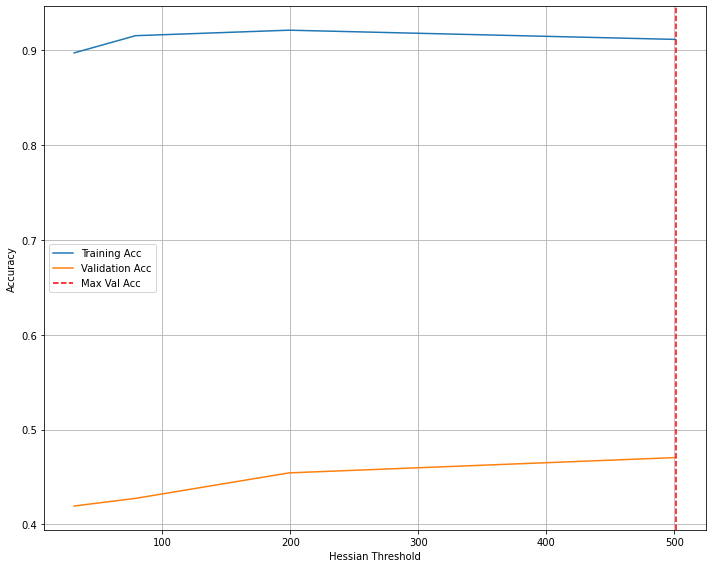

In [0]:
# hessian threshold
fig = plt.figure(figsize=(10,8))
plt.plot(hessian_t,train_accs_m_ht, label='Training Acc')
plt.plot(hessian_t,val_accs_m_ht,label='Validation Acc')

# find position of highest validation acc
maxposs = val_accs_m_ht.index(max(val_accs_m_ht)) 
plt.axvline(hessian_t[maxposs], linestyle='--', color='r',label='Max Val Acc')

plt.xlabel('Hessian Threshold')
plt.ylabel('Accuracy')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#fig.savefig('loss_plot.png', bbox_inches='tight')

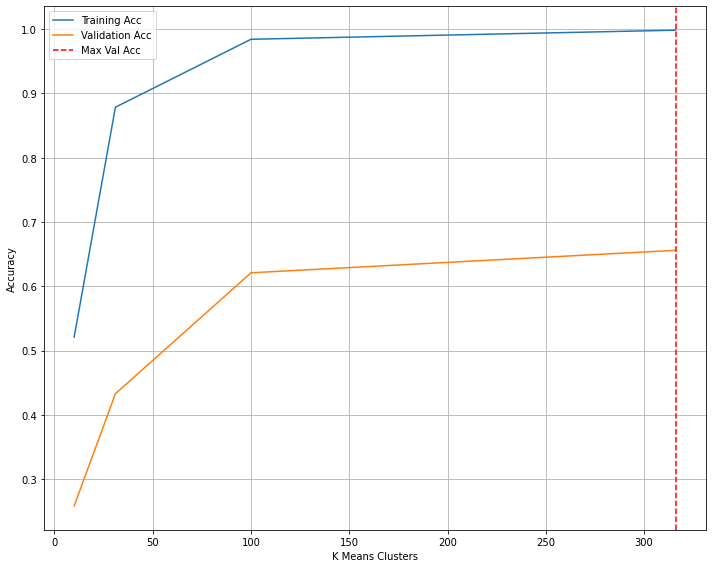

In [0]:
# k means clusters
fig = plt.figure(figsize=(10,8))
plt.plot(kmeans_k,train_accs_m_k, label='Training Acc')
plt.plot(kmeans_k,val_accs_m_k,label='Validation Acc')

# find position of highest validation acc
maxposs = val_accs_m_k.index(max(val_accs_m_k)) 
plt.axvline(kmeans_k[maxposs], linestyle='--', color='r',label='Max Val Acc')

plt.xlabel('K Means Clusters')
plt.ylabel('Accuracy')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#fig.savefig('loss_plot.png', bbox_inches='tight')

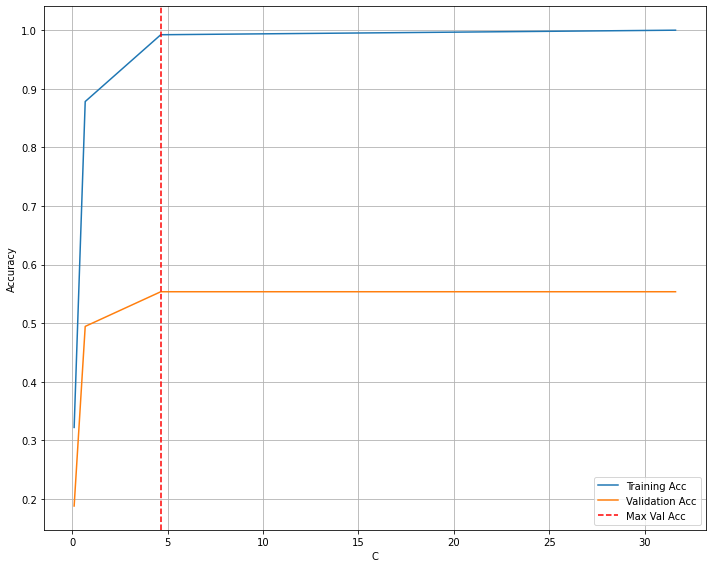

In [0]:
# SVM C regularisation parameter
fig = plt.figure(figsize=(10,8))
plt.plot(Cs,train_accs_m_c, label='Training Acc')
plt.plot(Cs,val_accs_m_c,label='Validation Acc')

# find position of highest validation acc
maxposs = val_accs_m_c.index(max(val_accs_m_c)) 
plt.axvline(Cs[maxposs], linestyle='--', color='r',label='Max Val Acc')

plt.xlabel('C')
plt.ylabel('Accuracy')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#fig.savefig('loss_plot.png', bbox_inches='tight')

### Show outputs

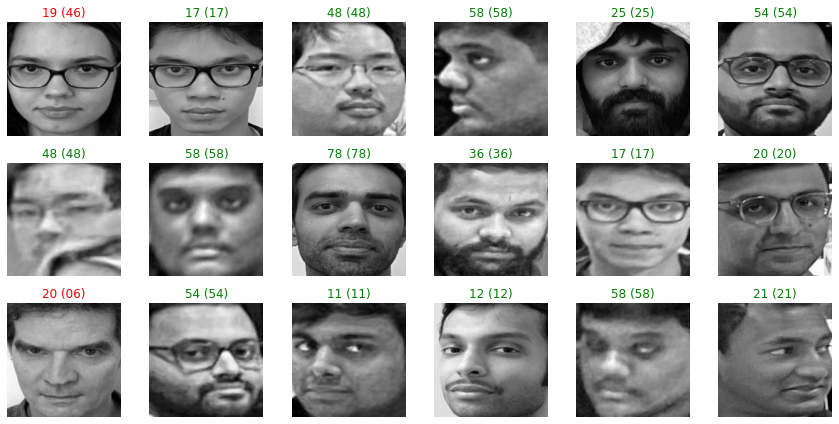

In [34]:
utils.visualise_svm(svc, extractor, images_val, labels_val, labels)

### Save model

In [35]:
# save kmeans for feature extraction
from joblib import dump, load
dump(extractor.kmeans, models_path + '/kmeans.joblib') 

['../models/kmeans.joblib']

In [36]:
# save model
from joblib import dump, load
dump(svc, models_path + '/surf_svm.joblib') 

['../models/surf_svm.joblib']

### Test model

In [0]:
# load test data (all)
test_faces = CustomDataset(test, transform=transform)
test_inputs = extractor([sample[0] for sample in test_faces])
test_labels = [sample[1] for sample in test_faces]

# load test data (individual images)
test_i_faces = CustomDataset(test_i, transform=transform)
test_i_inputs = extractor([sample[0] for sample in test_i_faces])
test_i_labels = [sample[1] for sample in test_i_faces]

# load test data (group images)
test_g_faces = CustomDataset(test_g, transform=transform)
test_g_inputs = extractor([sample[0] for sample in test_g_faces])
test_g_labels = [sample[1] for sample in test_g_faces]

In [0]:
# get predictions (entire test set)
preds = svc.predict(test_inputs)

# get predictions (individual images)
preds_i = svc.predict(test_i_inputs)

# get predictions (group images)
preds_g = svc.predict(test_g_inputs)

In [0]:
# get test set accuracy
acc_test = np.sum(preds == test_labels) / len(test_labels)
acc_test_i = np.sum(preds_i == test_i_labels) / len(test_i_labels)
acc_test_g = np.sum(preds_g == test_g_labels) / len(test_g_labels)

In [40]:
# print test set accuracy
{'test (all)': round(acc_test,3), 'test (i)': round(acc_test_i,3), 'test (g)': round(acc_test_g,3)}

{'test (all)': 0.655, 'test (g)': 0.612, 'test (i)': 0.732}

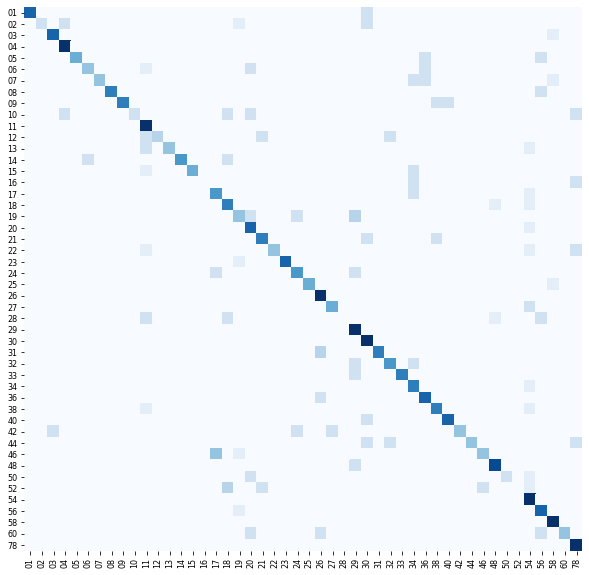

In [41]:
cm = confusion_matrix(test_labels, preds)
cm_df = pd.DataFrame(data=(cm/cm.sum(axis=1)).round(1), columns=labels, index=labels)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df,cmap=plt.cm.Blues,cbar=False)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

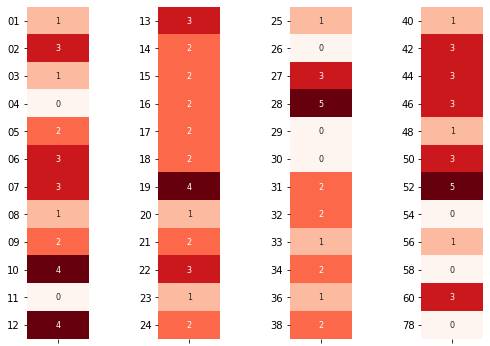

In [42]:
# show model's incorrect predictions per class
mistakes = cm.sum(axis=1) - np.diag(cm)

m_df_1 = pd.DataFrame(data=mistakes[0:12],columns=[''],index=labels[0:12])
m_df_2 = pd.DataFrame(data=mistakes[12:24],columns=[''],index=labels[12:24])
m_df_3 = pd.DataFrame(data=mistakes[24:36],columns=[''],index=labels[24:36])
m_df_4 = pd.DataFrame(data=mistakes[36:48],columns=[''],index=labels[36:48])

fig, ax = plt.subplots(1,4,figsize=(8,6))

sns.heatmap(m_df_1,cmap=plt.cm.Reds,vmin=0,vmax=4,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[0])
sns.heatmap(m_df_2,cmap=plt.cm.Reds,vmin=0,vmax=4,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[1])
sns.heatmap(m_df_3,cmap=plt.cm.Reds,vmin=0,vmax=4,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[2])
sns.heatmap(m_df_4,cmap=plt.cm.Reds,vmin=0,vmax=4,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[3])

ax[0].set_yticklabels(labels[0:12],rotation=0)
ax[1].set_yticklabels(labels[12:24],rotation=0)
ax[2].set_yticklabels(labels[24:36],rotation=0)
ax[3].set_yticklabels(labels[36:48],rotation=0)

plt.tight_layout(pad=5.0)
plt.show()

## PCA-MLP

### Prep data

In [0]:
#fit pca algo
extractor = utils.pca_extractor(pca_train_data=images_train, pca_n_comps=133)
pca = extractor.pca

In [0]:
# data transforms with augmentation
transform_aug = transforms.Compose([
                                utils.AugSeq(),
                                transforms.Grayscale(num_output_channels=1),
                                utils.pca_extractor(pca=pca, pca_n_comps=133),
                                transforms.ToTensor(),
                                ])

# data transforms no augmentation
transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=1),
                                utils.pca_extractor(pca=pca, pca_n_comps=133),
                                transforms.ToTensor(),
                                ])

In [0]:
# load train data
train_faces = CustomDataset(train, transform=transform_aug)

# load val data
val_faces = CustomDataset(val, transform=transform)

dataset_sizes = {'train': len(train_faces), 'val': len(val_faces)}
dataset_sizes

{'train': 612, 'val': 186}

### Train model

In [0]:
# create MLP architecture
class Net(nn.Module):
    def __init__(self, input_size, n_classes, dropout_rate=0.5):
        super(Net, self).__init__()
        #input_size = torch.FloatTensor([input_size])
        #n_classes = torch.FloatTensor([n_classes])
        hl_size = (input_size+n_classes)//2
        self.fc1 = nn.Linear(input_size, hl_size)
        self.fc2 = nn.Linear(hl_size, n_classes)
        self.dropout = nn.Dropout(dropout_rate)
    def forward(self, x):
        # flatten image input
        # x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # add output layer
        x = self.fc2(x)
        return x

In [0]:
# instantiate mlp
mlp = Net(input_size=extractor.pca_n_comps, n_classes=len(labels))
mlp = mlp.to(device)
print(mlp)

# specify loss function
criterion = nn.CrossEntropyLoss().to(device)

# specify optimizer
optimizer = torch.optim.Adam(mlp.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Net(
  (fc1): Linear(in_features=133, out_features=90, bias=True)
  (fc2): Linear(in_features=90, out_features=48, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [0]:
# adapted from https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
# and https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, batch_size, patience, n_epochs):

    # create train, val data loaders
    train_loader = DataLoader(train_faces, batch_size=batch_size, num_workers=0)
    val_loader = DataLoader(val_faces, batch_size=batch_size, num_workers=0)
    dataloaders = {'train': train_loader, 'val': val_loader}

    # to track the training loss per epoch as the model trains
    train_losses = []
    # to track the validation loss per epoch as the model trains
    valid_losses = [] 

    train_accs= []
    valid_accs = []
    
    # initialize the early_stopping object
    early_stopping = utils.EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.squeeze().to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                    
                    #if phase == 'train':
                        #scheduler.step()
              
            if phase == 'train':
                train_loss = running_loss / dataset_sizes[phase]
                train_acc = running_corrects.double() / dataset_sizes[phase]
                train_losses.append(train_loss)
                train_accs.append(train_acc)
            else:
                valid_loss = running_loss / dataset_sizes[phase]
                valid_acc = running_corrects.double() / dataset_sizes[phase]
                valid_losses.append(valid_loss)
                valid_accs.append(valid_acc)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.3f} ' +
                     f'train_acc: {train_acc:.3f} ' +
                     f'valid_loss: {valid_loss:.3f} ' + 
                     f'valid_acc: {valid_acc:.3f}')
        
        print(print_msg)
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  train_losses, valid_losses, train_accs, valid_accs

In [0]:
batch_size = 32
n_epochs = 100
patience = 15

# train model
train_loss, valid_loss, train_acc, valid_acc = train_model(mlp, batch_size, patience, n_epochs)

[  1/100] train_loss: 378.054 train_acc: 0.025 valid_loss: 195.819 valid_acc: 0.097
Validation loss decreased (inf --> 195.818654).  Saving model ...
[  2/100] train_loss: 286.764 train_acc: 0.052 valid_loss: 162.085 valid_acc: 0.167
Validation loss decreased (195.818654 --> 162.084891).  Saving model ...
[  3/100] train_loss: 230.493 train_acc: 0.101 valid_loss: 129.020 valid_acc: 0.199
Validation loss decreased (162.084891 --> 129.020137).  Saving model ...
[  4/100] train_loss: 189.947 train_acc: 0.124 valid_loss: 99.612 valid_acc: 0.231
Validation loss decreased (129.020137 --> 99.612027).  Saving model ...
[  5/100] train_loss: 162.673 train_acc: 0.157 valid_loss: 86.558 valid_acc: 0.290
Validation loss decreased (99.612027 --> 86.557925).  Saving model ...
[  6/100] train_loss: 132.763 train_acc: 0.168 valid_loss: 77.770 valid_acc: 0.290
Validation loss decreased (86.557925 --> 77.770216).  Saving model ...
[  7/100] train_loss: 124.309 train_acc: 0.209 valid_loss: 68.640 valid_a

### Show stats

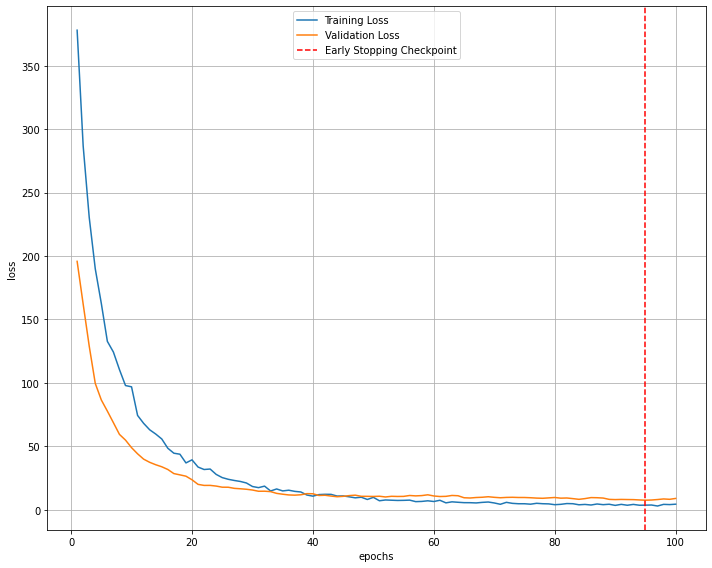

In [0]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#fig.savefig('loss_plot.png', bbox_inches='tight')

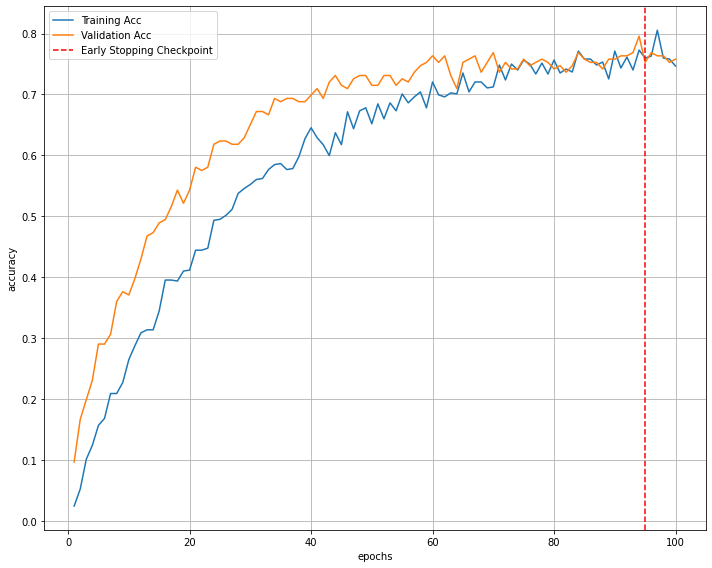

In [0]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Acc')
plt.plot(range(1,len(valid_acc)+1),valid_acc,label='Validation Acc')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#fig.savefig('loss_plot.png', bbox_inches='tight')

### Show outputs

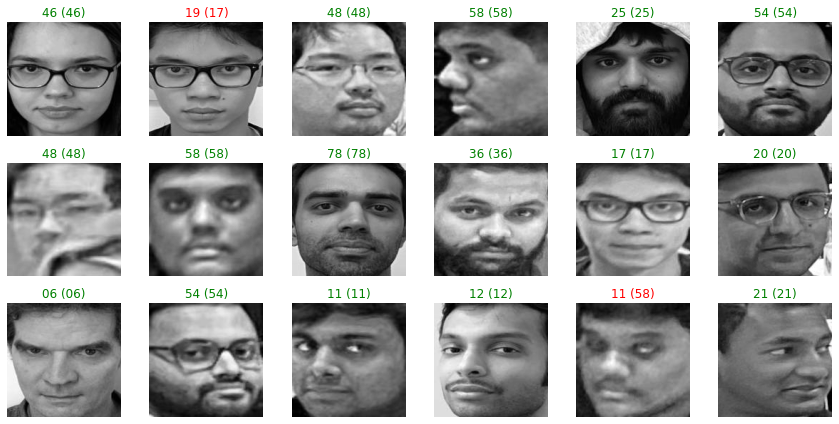

In [0]:
utils.visualise_mlp(mlp, extractor, images_val, labels_val, labels)

### Save model

In [0]:
# save pca for feature extraction
from joblib import dump, load
dump(extractor.pca, models_path + '/pca.joblib')

['../models/pca.joblib']

In [0]:
# save model down
torch.save(mlp.state_dict(), models_path + '/pca_mlp.pt')

### Test model

In [0]:
# load test data (all)
test_faces = CustomDataset(test, transform=transform)
test_inputs = torch.stack([sample[0] for sample in test_faces]).to(device)
test_labels = [sample[1] for sample in test_faces]

# load test data (individual images)
test_i_faces = CustomDataset(test_i, transform=transform)
test_i_inputs = torch.stack([sample[0] for sample in test_i_faces]).to(device)
test_i_labels = [sample[1] for sample in test_i_faces]

# load test data (group images)
test_g_faces = CustomDataset(test_g, transform=transform)
test_g_inputs = torch.stack([sample[0] for sample in test_g_faces]).to(device)
test_g_labels = [sample[1] for sample in test_g_faces]

In [0]:
mlp.eval()
# get predictions (entire test set)
outputs = mlp(test_inputs.squeeze())
scores, preds = outputs.max(1)
preds = preds.cpu().detach().numpy()

# get predictions (individual images)
outputs_i = mlp(test_i_inputs.squeeze())
scores_i, preds_i = outputs_i.max(1)
preds_i = preds_i.cpu().detach().numpy()

# get predictions (group images)
outputs_g = mlp(test_g_inputs.squeeze())
scores_g, preds_g = outputs_g.max(1)
preds_g = preds_g.cpu().detach().numpy()

In [0]:
# get test set accuracy
acc_test = np.sum(preds == test_labels) / len(test_labels)
acc_test_i = np.sum(preds_i == test_i_labels) / len(test_i_labels)
acc_test_g = np.sum(preds_g == test_g_labels) / len(test_g_labels)

In [0]:
# print test set accuracy
{'test (all)': round(acc_test,3), 'test (i)': round(acc_test_i,3), 'test (g)': round(acc_test_g,3)}

{'test (all)': 0.772, 'test (g)': 0.776, 'test (i)': 0.763}

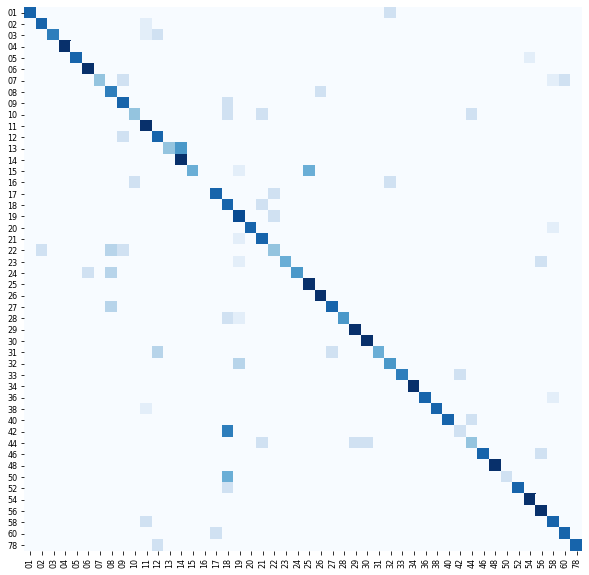

In [0]:
cm = confusion_matrix(test_labels, preds)
cm_df = pd.DataFrame(data=(cm/cm.sum(axis=1)).round(1), columns=labels, index=labels)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df,cmap=plt.cm.Blues,cbar=False)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

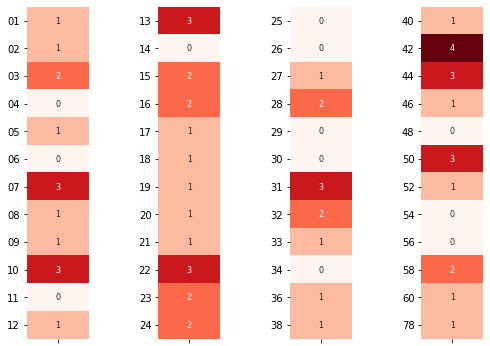

In [0]:
# show model's incorrect predictions per class
mistakes = cm.sum(axis=1) - np.diag(cm)

m_df_1 = pd.DataFrame(data=mistakes[0:12],columns=[''],index=labels[0:12])
m_df_2 = pd.DataFrame(data=mistakes[12:24],columns=[''],index=labels[12:24])
m_df_3 = pd.DataFrame(data=mistakes[24:36],columns=[''],index=labels[24:36])
m_df_4 = pd.DataFrame(data=mistakes[36:48],columns=[''],index=labels[36:48])

fig, ax = plt.subplots(1,4,figsize=(8,6))

sns.heatmap(m_df_1,cmap=plt.cm.Reds,vmin=0,vmax=4,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[0])
sns.heatmap(m_df_2,cmap=plt.cm.Reds,vmin=0,vmax=4,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[1])
sns.heatmap(m_df_3,cmap=plt.cm.Reds,vmin=0,vmax=4,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[2])
sns.heatmap(m_df_4,cmap=plt.cm.Reds,vmin=0,vmax=4,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[3])

ax[0].set_yticklabels(labels[0:12],rotation=0)
ax[1].set_yticklabels(labels[12:24],rotation=0)
ax[2].set_yticklabels(labels[24:36],rotation=0)
ax[3].set_yticklabels(labels[36:48],rotation=0)

plt.tight_layout(pad=5.0)
plt.show()

## SURF-MLP

### Prep data

In [0]:
#fit kmeans algo
extractor = utils.surf_extractor(kmeans_train_data=images_train, hessian_threshold=31, n_clusters=316)
kmeans = extractor.kmeans

In [0]:
# data transforms with augmentation
transform_aug = transforms.Compose([
                                utils.AugSeq(),
                                transforms.Grayscale(num_output_channels=1),
                                utils.surf_extractor(kmeans=kmeans, hessian_threshold=31, n_clusters=316),
                                transforms.ToTensor(),
                                ])

# data transforms no augmentation
transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=1),
                                utils.surf_extractor(kmeans=kmeans, hessian_threshold=31, n_clusters=316),
                                transforms.ToTensor(),
                                ])

In [0]:
# load train data
train_faces = CustomDataset(train, transform=transform_aug)

# load val data
val_faces = CustomDataset(val, transform=transform)

dataset_sizes = {'train': len(train_faces), 'val': len(val_faces)}
dataset_sizes

{'train': 612, 'val': 186}

### Train model

In [0]:
# create MLP architecture
class Net(nn.Module):
    def __init__(self, input_size, n_classes, dropout_rate=0.5):
        super(Net, self).__init__()
        #input_size = torch.FloatTensor([input_size])
        #n_classes = torch.FloatTensor([n_classes])
        hl_size = (input_size+n_classes)//2
        self.fc1 = nn.Linear(input_size, hl_size)
        self.fc2 = nn.Linear(hl_size, n_classes)
        self.dropout = nn.Dropout(dropout_rate)
    def forward(self, x):
        # flatten image input
        # x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # add output layer
        x = self.fc2(x)
        return x

In [0]:
# instantiate mlp
mlp = Net(input_size=extractor.n_clusters, n_classes=len(labels))
mlp = mlp.to(device)
print(mlp)

# specify loss function
criterion = nn.CrossEntropyLoss().to(device)

# specify optimizer
optimizer = torch.optim.Adam(mlp.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Net(
  (fc1): Linear(in_features=316, out_features=182, bias=True)
  (fc2): Linear(in_features=182, out_features=48, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [0]:
def train_model(model, batch_size, patience, n_epochs):

    # create train, val data loaders
    train_loader = DataLoader(train_faces, batch_size=batch_size, num_workers=0)
    val_loader = DataLoader(val_faces, batch_size=batch_size, num_workers=0)
    dataloaders = {'train': train_loader, 'val': val_loader}

    # to track the training loss per epoch as the model trains
    train_losses = []
    # to track the validation loss per epoch as the model trains
    valid_losses = [] 

    train_accs= []
    valid_accs = []
    
    # initialize the early_stopping object
    early_stopping = utils.EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.squeeze().to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                    
                    #if phase == 'train':
                        #scheduler.step()
              
            if phase == 'train':
                train_loss = running_loss / dataset_sizes[phase]
                train_acc = running_corrects.double() / dataset_sizes[phase]
                train_losses.append(train_loss)
                train_accs.append(train_acc)
            else:
                valid_loss = running_loss / dataset_sizes[phase]
                valid_acc = running_corrects.double() / dataset_sizes[phase]
                valid_losses.append(valid_loss)
                valid_accs.append(valid_acc)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.3f} ' +
                     f'train_acc: {train_acc:.3f} ' +
                     f'valid_loss: {valid_loss:.3f} ' + 
                     f'valid_acc: {valid_acc:.3f}')
        
        print(print_msg)
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  train_losses, valid_losses, train_accs, valid_accs

In [0]:
batch_size = 32
n_epochs = 100
patience = 15

# train model
train_loss, valid_loss, train_acc, valid_acc = train_model(mlp, batch_size, patience, n_epochs)

[  1/100] train_loss: 3.789 train_acc: 0.075 valid_loss: 3.646 valid_acc: 0.091
Validation loss decreased (inf --> 3.645989).  Saving model ...
[  2/100] train_loss: 3.575 train_acc: 0.136 valid_loss: 3.496 valid_acc: 0.113
Validation loss decreased (3.645989 --> 3.495672).  Saving model ...
[  3/100] train_loss: 3.400 train_acc: 0.160 valid_loss: 3.283 valid_acc: 0.151
Validation loss decreased (3.495672 --> 3.282955).  Saving model ...
[  4/100] train_loss: 3.209 train_acc: 0.212 valid_loss: 3.061 valid_acc: 0.210
Validation loss decreased (3.282955 --> 3.061341).  Saving model ...
[  5/100] train_loss: 2.969 train_acc: 0.276 valid_loss: 2.826 valid_acc: 0.290
Validation loss decreased (3.061341 --> 2.826108).  Saving model ...
[  6/100] train_loss: 2.805 train_acc: 0.335 valid_loss: 2.610 valid_acc: 0.349
Validation loss decreased (2.826108 --> 2.609723).  Saving model ...
[  7/100] train_loss: 2.574 train_acc: 0.408 valid_loss: 2.411 valid_acc: 0.419
Validation loss decreased (2.60

### Show stats

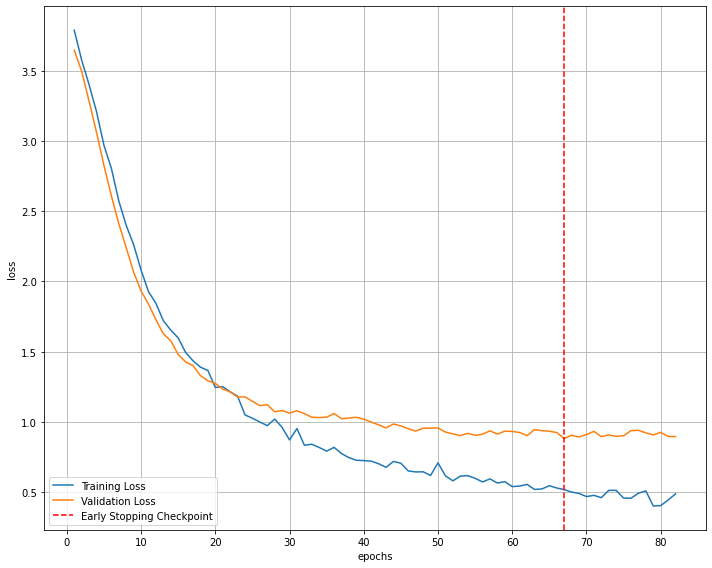

In [0]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#fig.savefig('loss_plot.png', bbox_inches='tight')

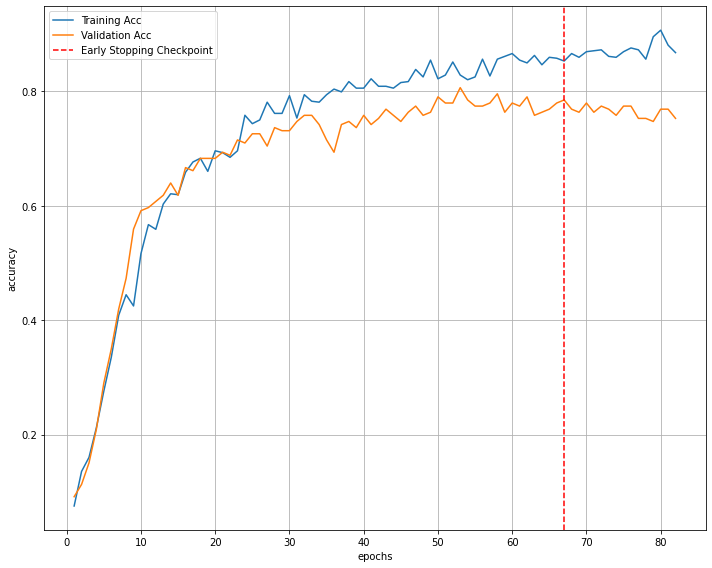

In [0]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Acc')
plt.plot(range(1,len(valid_acc)+1),valid_acc,label='Validation Acc')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#fig.savefig('loss_plot.png', bbox_inches='tight')

### Show outputs

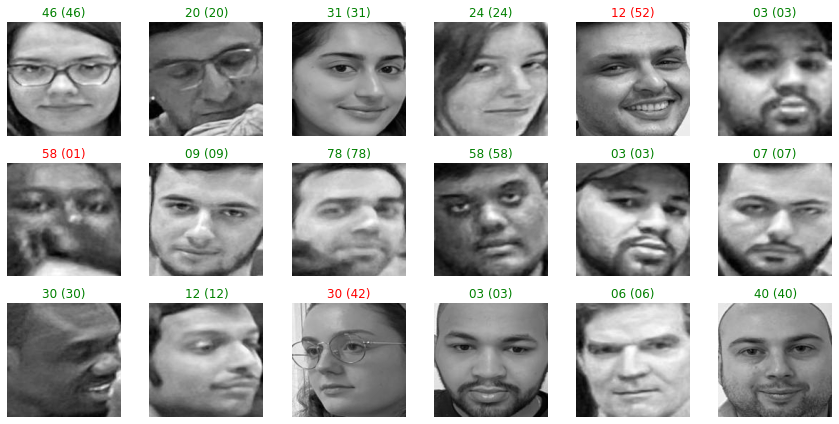

In [0]:
utils.visualise_mlp(mlp, extractor, images_val, labels_val, labels)

### Save model

In [0]:
# save kmeans for feature extraction
from joblib import dump, load
dump(extractor.kmeans, models_path + '/kmeans.joblib') 

['../models/kmeans.joblib']

In [0]:
# save model down
torch.save(mlp.state_dict(), models_path + '/surf_mlp.pt')

### Test model

In [0]:
# load test data (all)
test_faces = CustomDataset(test, transform=transform)
test_inputs = torch.stack([sample[0] for sample in test_faces]).to(device)
test_labels = [sample[1] for sample in test_faces]

# load test data (individual images)
test_i_faces = CustomDataset(test_i, transform=transform)
test_i_inputs = torch.stack([sample[0] for sample in test_i_faces]).to(device)
test_i_labels = [sample[1] for sample in test_i_faces]

# load test data (group images)
test_g_faces = CustomDataset(test_g, transform=transform)
test_g_inputs = torch.stack([sample[0] for sample in test_g_faces]).to(device)
test_g_labels = [sample[1] for sample in test_g_faces]

In [0]:
mlp.eval()
# get predictions (entire test set)
outputs = mlp(test_inputs.squeeze())
scores, preds = outputs.max(1)
preds = preds.cpu().detach().numpy()

# get predictions (individual images)
outputs_i = mlp(test_i_inputs.squeeze())
scores_i, preds_i = outputs_i.max(1)
preds_i = preds_i.cpu().detach().numpy()

# get predictions (group images)
outputs_g = mlp(test_g_inputs.squeeze())
scores_g, preds_g = outputs_g.max(1)
preds_g = preds_g.cpu().detach().numpy()

In [0]:
# get test set accuracy
acc_test = np.sum(preds == test_labels) / len(test_labels)
acc_test_i = np.sum(preds_i == test_i_labels) / len(test_i_labels)
acc_test_g = np.sum(preds_g == test_g_labels) / len(test_g_labels)

In [0]:
# print test set accuracy
{'test (all)': round(acc_test,3), 'test (i)': round(acc_test_i,3), 'test (g)': round(acc_test_g,3)}

{'test (all)': 0.708, 'test (g)': 0.676, 'test (i)': 0.763}

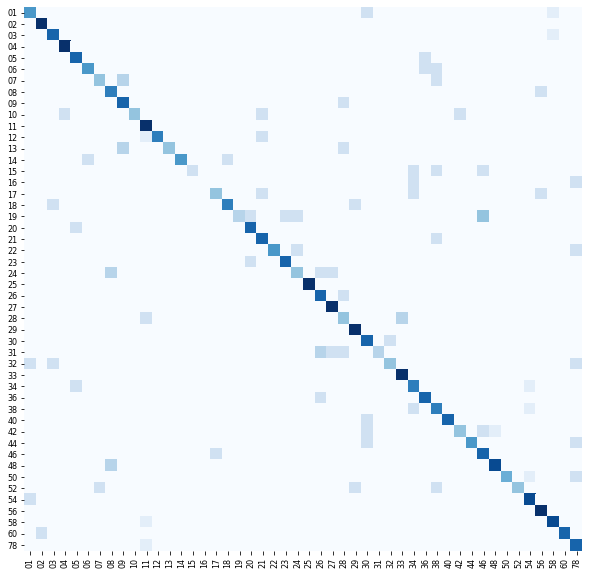

In [0]:
cm = confusion_matrix(test_labels, preds)
cm_df = pd.DataFrame(data=(cm/cm.sum(axis=1)).round(1), columns=labels, index=labels)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df,cmap=plt.cm.Blues,cbar=False)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

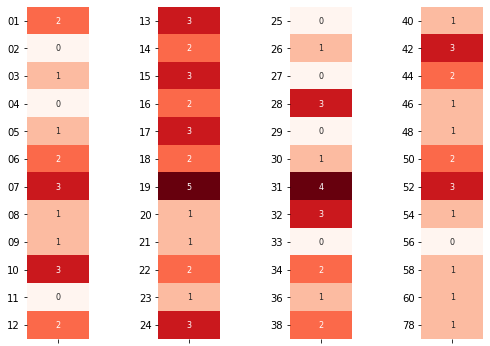

In [0]:
# show model's incorrect predictions per class
mistakes = cm.sum(axis=1) - np.diag(cm)

m_df_1 = pd.DataFrame(data=mistakes[0:12],columns=[''],index=labels[0:12])
m_df_2 = pd.DataFrame(data=mistakes[12:24],columns=[''],index=labels[12:24])
m_df_3 = pd.DataFrame(data=mistakes[24:36],columns=[''],index=labels[24:36])
m_df_4 = pd.DataFrame(data=mistakes[36:48],columns=[''],index=labels[36:48])

fig, ax = plt.subplots(1,4,figsize=(8,6))

sns.heatmap(m_df_1,cmap=plt.cm.Reds,vmin=0,vmax=4,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[0])
sns.heatmap(m_df_2,cmap=plt.cm.Reds,vmin=0,vmax=4,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[1])
sns.heatmap(m_df_3,cmap=plt.cm.Reds,vmin=0,vmax=4,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[2])
sns.heatmap(m_df_4,cmap=plt.cm.Reds,vmin=0,vmax=4,cbar=False,annot=True, annot_kws={"fontsize":8},ax=ax[3])

ax[0].set_yticklabels(labels[0:12],rotation=0)
ax[1].set_yticklabels(labels[12:24],rotation=0)
ax[2].set_yticklabels(labels[24:36],rotation=0)
ax[3].set_yticklabels(labels[36:48],rotation=0)

plt.tight_layout(pad=5.0)
plt.show()